# 2. Análise exploratória

Com os dados sanitizados, é possível agora verificar algumas distribuições das variáveis disponíveis, para entender como é o perfil dos clientes e das características dos laboratórios

Com base nestas distribuições, será possível aprofundar as análises, orientando pelas perguntas de negócio que queremos responder

### importando as bibliotecas necessárias

In [127]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True) 

%matplotlib inline

### lendo as bases de dados tratadas

In [140]:
demographic_data = pd.read_csv('dados_tratados/demographic_data_trat.csv')
df_geocode = pd.read_csv('dados_tratados/df_geocode_trat.csv')
economic_data = pd.read_csv('dados_tratados/economic_data_trat.csv')
test_data = pd.read_csv('dados_tratados/test_data_trat.csv')
transactional_data = pd.read_csv('dados_tratados/transactional_data_trat.csv')

zipcodes_states = pd.read_excel('dados_brutos/zipcodes-states.xlsx', index_col = 0) # fontes: https://codigo-postal.co/pt-br/eua/, https://pt.wikipedia.org/wiki/Lista_de_estados_dos_Estados_Unidos_por_popula%C3%A7%C3%A3o

C:\Users\Leticia\AppData\Local\Temp\ipykernel_14452\3369382902.py:5: DtypeWarning:

Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.



## mapa com a distribuição das localizações

inicialmente, será produzido um mapa dos estados unidos com a localização dos laboratórios

para isso, será utilizada a base df_geocode, que tem as informações de latitude e longitude dos laboratórios 

In [129]:
coordenadas = df_geocode

# separando a latitude e a longitude
coordenadas['latitude'] = coordenadas['Location'].str.split(',').str[0].astype('float')
coordenadas['longitude'] = coordenadas['Location'].str.split(',').str[1].astype('float')

# separando o estado a partir da coluna de endereço
coordenadas['state'] = coordenadas['Address'].str.split(', ').str[2].str.split(' ').str[0]

coordenadas.head()

,Lab Id,Address,Location,Zipcode,latitude,longitude,state
0,L152,"3800 PLEASANT HILL RD STE 1, DULUTH, GA 30096","34.000319,-84.1629724",30096.0,34.000319,-84.162972,GA
1,L520,"1614 N JAMES ST, ROME, NY 13440","43.2311327,-75.4445363",13440.0,43.231133,-75.444536,NY
2,L141,"12911 120TH AVE NE STE D60, KIRKLAND, WA 98034","47.7162786,-122.1838152",98034.0,47.716279,-122.183815,WA
3,L524,"5667 PEACHTREE DUNWOODY RD 250, ATLANTA, GA 30342","33.9093875,-84.3529096",30342.0,33.909388,-84.352910,GA
4,L545,"1204 IL HWY 164, OQUAWKA, IL 61469","40.9309925,-90.9437598",61469.0,40.930993,-90.943760,IL


quais são os estados que têm laboratórios? quantos laboratórios tem em cada um deles?

In [172]:
zipcodes_states.head(3)

,Sigla,Estado,Estado.1,Intervalo de CEPs,Qtd de CEPs,Data de Fundação,População 2020
21,MA,Massachusetts,Boston,01001 to 02544,703,"February 6, 1788",7 029 917
39,RI,Rhode Island,Providence,02801 to 02940,91,"May 19, 1790",1 097 379
29,NH,New Hampshire,Concord,03031 to 03897,284,"June 21, 1788",1 377 529


In [179]:
estados = coordenadas.groupby('state').count()[['Lab Id']].sort_values('Lab Id', ascending = False).reset_index()

estados = estados.rename({'state':'Sigla'}, axis = 1)

estados = estados.merge(zipcodes_states[['Estado', 'Sigla']], how = 'left')

estados

,Sigla,Lab Id,Estado
0,WA,20,Washington
1,CA,18,California
2,GA,18,Georgia
3,PA,17,Pennsylvania
4,MA,12,Massachusetts
5,NY,11,New York
6,IL,6,Illinois
7,IA,5,Iowa
8,NH,4,New Hampshire
9,NJ,3,New Jersey


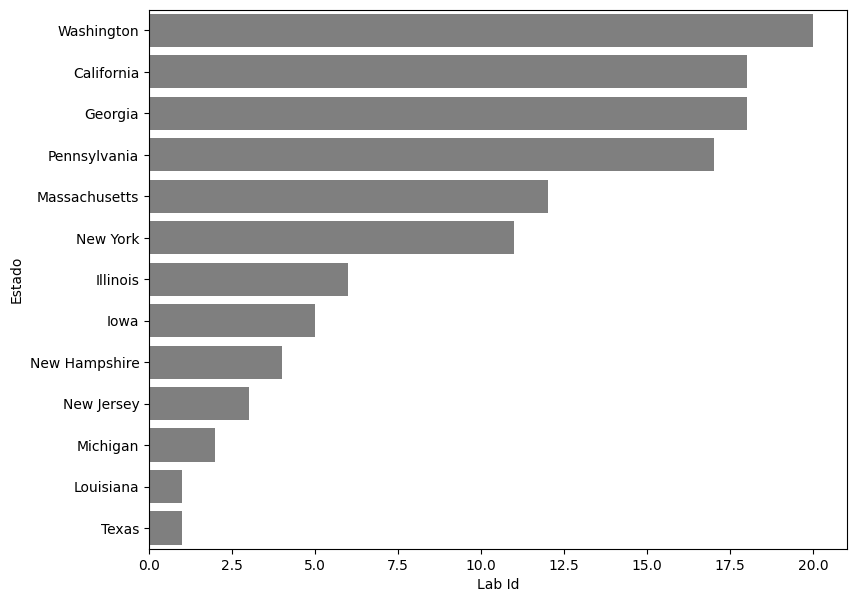

In [195]:
plt.figure(figsize = (9, 7))
fig = sns.barplot(data = estados, x = 'Lab Id', y = 'Estado', color = '#7f7f7f')

construindo o gráfico de mapa para visualizar as localizações - estão próximos uns dos outros ou mais espalhados pelos EUA?

In [167]:
data = dict(
    type = 'scattergeo',
    # colorscale = 'RdBu',
    lat = coordenadas['latitude'],
    lon = coordenadas['longitude'],
    # locations = coordenadas['state'],
    # locationmode = 'USA-states',
    # z = coordenadas['Lab Id'],
    # text = coordenadas['Address'],
    marker = dict(size = 5, autocolorscale = False, colorscale = 'Bluered', color = coordenadas['Zipcode']),
    # colorbar = dict(title = 'Zipcode')
)

layout = dict(
    title = 'Localizações dos laboratórios',
    geo = dict(scope = 'usa', # showlakes = True, lakecolor = 'rgb(85, 173, 240)',
               projection = dict(type ='albers usa'),showland = True,
                    landcolor="rgb(250,250,250)",subunitcolor = "rgb(100,100,100)",
                     countrycolor = "rgb(100,100,100)",countrywidth =0.5, subunitwidth=0.5)
)

choromap = go.Figure(data = [data], layout = layout)


choromap.update_layout(width=700)
iplot(choromap, validate = False)


observando o mapa, é possível concluir que os laboratórios possuem pequenas concentrações espalhadas pelo país. 

é possível que as unidades estejam próximas para tentar consolidar uma clientela forte nestes locais e para facilitar a logística

## distribuição das variáveis dos clientes

## distribuição das variáveis dos testes e dos laboratórios

## aprofundamentos

### dataframe com a população e o intervalo de zipcodes de cada estado dos EUA

In [108]:
zipcodes_states['População 2020'] = zipcodes_states['População 2020'].apply(lambda x: "".join(x.split())).astype('int')
zipcodes_states['primeiro_zipcode'] = zipcodes_states['Intervalo de CEPs'].apply(lambda x: "".join(x.split())).str.split('to').str[0].astype('float')
zipcodes_states['ultimo_zipcode'] = zipcodes_states['Intervalo de CEPs'].apply(lambda x: "".join(x.split())).str.split('to').str[1].astype('float')

zipcodes_states.sort_values('primeiro_zipcode').head()

,Sigla,Estado,Estado.1,Intervalo de CEPs,Qtd de CEPs,Data de Fundação,População 2020,primeiro_zipcode,ultimo_zipcode
21,MA,Massachusetts,Boston,01001 to 02544,703,"February 6, 1788",7029917,1001.0,2544.0
39,RI,Rhode Island,Providence,02801 to 02940,91,"May 19, 1790",1097379,2801.0,2940.0
29,NH,New Hampshire,Concord,03031 to 03897,284,"June 21, 1788",1377529,3031.0,3897.0
19,ME,Maine,Augusta,03901 to 04992,488,"March 15, 1820",1362359,3901.0,4992.0
45,VT,Vermont,Montpelier,05001 to 05907,309,"March 4, 1791",643077,5001.0,5907.0


In [106]:
merged_df = df_geocode.merge(zipcodes_states[['Estado', 'primeiro_zipcode', 'ultimo_zipcode']], left_on='Zipcode', right_on=lambda x: (zipcodes_states['primeiro_zipcode'] <= x) & (x <= zipcodes_states['ultimo_zipcode']))

merged_df

KeyError: <function <lambda> at 0x00000289324371C0>